In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *
from plotting_functions import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

### Initialise data loader

In [4]:
lim = [0,1200] # limit recording times - in seconds
include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
#include_actions = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions


print("load #spikes: ", len(spikes))

"""
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {len(spikes) / len(include_actions)}")
"""

spatial_map = sp.SpatialMap()

load #spikes:  124


In [5]:
spikes.sort(key=lambda sptr: sptr.annotations["mua_quality"],reverse=True)
spikes.sort(key=lambda sptr: sptr.annotations["action_id"])
spikes.sort(key=lambda sptr: sptr.annotations["unit_idnum"])
spikes.sort(key=lambda sptr: len(sptr.annotations["persistent_trials"]),reverse=True)
include_actions.sort()

"""
for sptr in spikes:
    print(sptr.annotations["action_id"], sptr.annotations["unit_idnum"], len(sptr.annotations["persistent_trials"]))
"""
_=2

In [6]:
unique_unsorted_unit_idnums = []
for sptr in spikes:
    if sptr.annotations["unit_idnum"] not in unique_unsorted_unit_idnums:
        unique_unsorted_unit_idnums.append(sptr.annotations["unit_idnum"])

/home/vemundss/anaconda3/envs/ca2mec/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


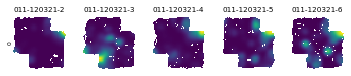

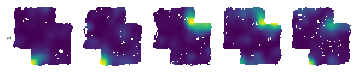

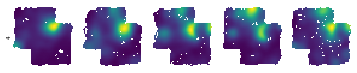

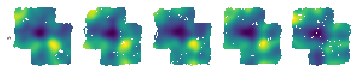

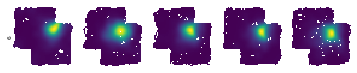

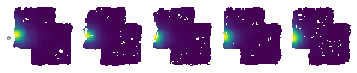

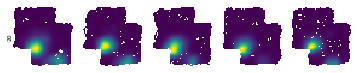

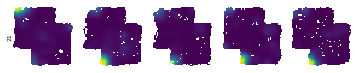

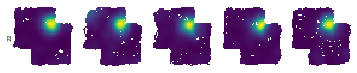

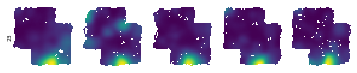

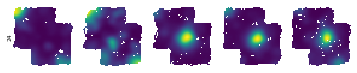

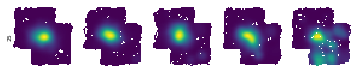

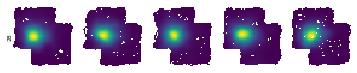

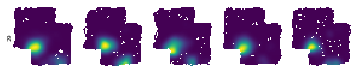

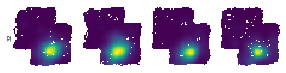

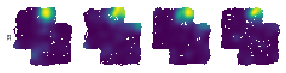

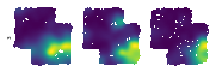

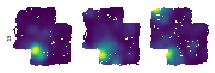

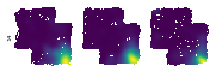

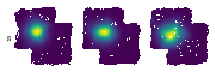

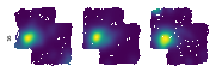

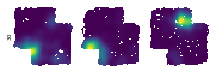

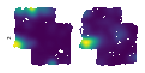

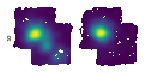

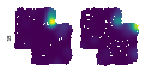

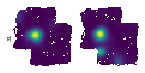

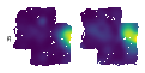

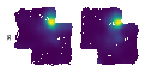

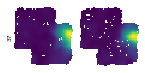

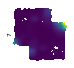

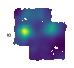

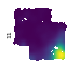

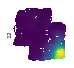

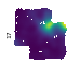

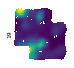

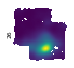

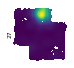

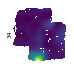

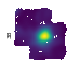

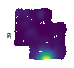

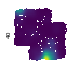

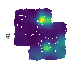

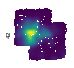

In [7]:
# sort on unit id
figscale = 1

add_title = True
for unit_idnum in unique_unsorted_unit_idnums:
    unit_spikes = [spike_train for spike_train in spikes if spike_train.annotations["unit_idnum"] == unit_idnum]
    fig,axs = plt.subplots(ncols=len(unit_spikes),figsize=(len(unit_spikes)*figscale, 1*figscale))
    axs = np.array([axs]) if type(axs) != np.ndarray else axs
    for ax, spike_train in zip(axs, unit_spikes):
        x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
        ratemap = spatial_map.rate_map(x, y, t, spike_train)
        ax.imshow(ratemap.T,origin='lower')
        axis_off_labels_on(ax)
        
        # add action_id title to first few plots
        if add_title:
            ax.set_title(spike_train.annotations["action_id"])
    add_title = False
    
    axs[0].set_ylabel(spike_train.annotations["unit_idnum"])